In [210]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import graphingFunctions as gf
import modelingFunctions as mf
importlib.reload(gf)
importlib.reload(mf)

<module 'modelingFunctions' from 'c:\\Users\\zacha\\Documents\\co3093-cw\\modelingFunctions.py'>

In [211]:
def markOutliers(df,columns):

    t = np.zeros(df.shape[0])
    z = np.zeros(df.shape[0])
    for column in columns:
        mean=np.mean(df[column])
        sd=np.std(df[column])
        threshold=2
        test=[]

        for i, x in enumerate(df[column]):
            if column=="SALE_PRICE":
                if x<75000:
                    t[i]=1
            z[i]=(x-mean)/sd
            if z[i]>=threshold:
                test.append((x,z[i]))
                t[i]=1
    df['outlier']=t
    
    return df

In [212]:
def categorizeNeighborhood(df):
    group = df.groupby("NEIGHBORHOOD")["SALE_PRICE"].mean().reset_index()
    group = group.rename(columns={"SALE_PRICE": "AVG_SALE_PRICE"})
    
    df = pd.merge(df, group, on="NEIGHBORHOOD", how="left")
    
    bins = [-np.inf, group["AVG_SALE_PRICE"].quantile(1/3), group["AVG_SALE_PRICE"].quantile(2/3), np.inf]
    n_cat = pd.cut(df["AVG_SALE_PRICE"], bins=bins, labels=[1,2,3])
    df = df.join(n_cat, rsuffix='_CATEGORY')
    return df

In [213]:
def markOutliersPerNieghborhood(df):
    groupedDF = df.groupby("NEIGHBORHOOD")
    t = np.zeros(df.shape[0])
    for n, g in groupedDF:
        q1 = g['lnprice'].quantile(0.25)
        q3 = g['lnprice'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        for i, r in g.iterrows():
            if not pd.isnull(r['lnprice']) and (r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound and r['lnprice']!=0):
                t[i] = 1
    q1 = df['lnprice'].quantile(0.25)
    q3 = df['lnprice'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    for i, r in df.iterrows():
        if not pd.isnull(r['lnprice']) and (r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound and r['lnprice']!=0):
            t[i] = 1
            
    for n, g in groupedDF:
        q1 = g['SALE_PRICE'].quantile(0.25)
        q3 = g['SALE_PRICE'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        for i, r in g.iterrows():
            if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_bound or r['SALE_PRICE'] >= upper_bound and r['SALE_PRICE']!=0):
                t[i] = 1
    q1 = df['SALE_PRICE'].quantile(0.25)
    q3 = df['SALE_PRICE'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    for i, r in df.iterrows():
        if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_bound or r['SALE_PRICE'] >= upper_bound and r['SALE_PRICE']!=0):
            t[i] = 1
    df['outlier']=t
    return df

def markOutliersPerNieghborhoodSP(df):
    groupedDF = df.groupby("NEIGHBORHOOD")
    t = np.zeros(df.shape[0])
    for n, g in groupedDF:
        q1 = g['SALE_PRICE'].quantile(0.25)
        q3 = g['SALE_PRICE'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        for i, r in g.iterrows():
            if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_bound or r['SALE_PRICE'] >= upper_bound and r['SALE_PRICE']!=0):
                t[i] = 1
    q1 = df['SALE_PRICE'].quantile(0.25)
    q3 = df['SALE_PRICE'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    for i, r in df.iterrows():
        if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_bound or r['SALE_PRICE'] >= upper_bound and r['SALE_PRICE']!=0):
            t[i] = 1
    df['outlier']=t
    return df

def checkUnits(df):
    t = np.zeros(df.shape[0])
    for i, r in df.iterrows():
        if r["RESIDENTIAL_UNITS"]==0 and r["COMMERCIAL_UNITS"]==0 and pd.isnull(r["TOTAL_UNITS"]):
            t[i]=1
        if r["LAND_SQUARE_FEET"]==0 and r["GROSS_SQUARE_FEET"]==0 and r["SALE_PRICE"]==0:
            t[i]=1
    df['no_units']=t
    return df   

def fillSquareFeet(df, column):
    dfComplete=df.copy()
    dfComplete[column]=dfComplete[column].replace(0,np.NaN)
    mean=dfComplete.groupby('NEIGHBORHOOD')[column].mean()
    dfComplete[column].fillna(dfComplete["NEIGHBORHOOD"].map(mean), inplace=True)
    
    return dfComplete

def fillYearBuilt(df):
    dfComplete=df.copy()
    dfComplete["YEAR_BUILT"]=dfComplete["YEAR_BUILT"].replace(0,np.NaN)
    dfComplete.loc[dfComplete["YEAR_BUILT"] < 1800, "YEAR_BUILT"] = np.nan
    median=dfComplete.groupby(['BLOCK', 'NEIGHBORHOOD'])['YEAR_BUILT'].median()
    median_rounded = median.round().astype('Int64')
    dfComplete["YEAR_BUILT"].fillna(dfComplete.groupby(['BLOCK', 'NEIGHBORHOOD'])["YEAR_BUILT"].transform(lambda x: x.fillna(median_rounded[x.name])), inplace=True)
    
    return dfComplete

def fillBuildingCategory(df):
    dfComplete=df.copy()
    dfComplete['BUILDING_CLASS_CATEGORY'].fillna(dfComplete.groupby(["BUILDING_CLASS_AT_PRESENT", "BUILDING_CLASS_AT_TIME_OF_SALE"])['BUILDING_CLASS_CATEGORY'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan).astype('object'), inplace=True)
    #dfComplete.groupby(["BUILDING_CLASS_AT_PRESENT", "BUILDING_CLASS_AT_TIME_OF_SALE"])['BUILDING_CLASS_CATEGORY'].apply(lambda x: print(x.mode()[0] if len(x.mode()) > 0 else np.nan))
    return dfComplete


In [214]:
def fillBasedOnCoef(dforigin, target, col1, col2):
    updated = False
    df=dforigin.copy()
    dfComplete=df.copy()
    dfComplete[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]]=dfComplete[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]].replace(0,np.NaN)
    dfComplete.dropna(inplace=True)
    x=dfComplete[[col1, col2]]
    y=dfComplete[target]

    model = linear_model.LinearRegression().fit(x, y)

    first_coef = model.coef_[0]
    sec_coef = model.coef_[1]
    df[target]=df[target].replace(np.NaN, 0)
    df[target] = np.where((df[target] == 0) & (df[col1] > 0) & (df[col2] > 0),
        (df[col1] * first_coef) + (df[col2] * sec_coef),df[target])
    if df[target].eq(dforigin[target]).all():
        updated = True
    df[target]=df[target].replace(0, np.NaN)
    return df, updated

In [215]:

def regressionFillSL(df):
    import statsmodels.formula.api as smf
    dfComplete=df.copy()
    dfComplete[['SALE_PRICE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']]=dfComplete[['SALE_PRICE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']].replace(0,np.NaN)
    dfComplete.dropna(inplace=True)
    dfComplete.reset_index(drop=True, inplace=True)
 
    model = smf.ols(formula='SALE_PRICE~LAND_SQUARE_FEET', data=dfComplete).fit()
    print(model.params)
    print('R squared is: ', model.rsquared)
    print(model.summary())

def regressionFillSG(df):
    import statsmodels.formula.api as smf
    dfComplete=df.copy()
    dfComplete[['SALE_PRICE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']]=dfComplete[['SALE_PRICE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']].replace(0,np.NaN)
    dfComplete.dropna(inplace=True)
    dfComplete.reset_index(drop=True, inplace=True)
 
    model = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET', data=dfComplete).fit()
    print(model.params)
    print('R squared is: ', model.rsquared)
    print(model.summary())


In [216]:
def step2_clean():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print(df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'
    ]
    df.columns=df.columns.str.replace(' ', '_')

    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    df[numerical]=df[numerical].apply(pd.to_numeric)

    #df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET", "SALE_PRICE"]]=df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET", "SALE_PRICE"]].replace(0, np.NaN)
    #print(df.isnull().sum())
    df["SALE_PRICE"]=df["SALE_PRICE"].replace(0, np.NaN)
    
    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df=fillYearBuilt(df)
      
    
    df['lnprice']=np.log(df["SALE_PRICE"])
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['lnprice'],inplace=True)
    print(df.columns)
   
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)
    df=mf.itImputations(df,['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE'])
    
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['lnprice']=np.log(df["SALE_PRICE"])
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(df.shape, df.isnull().sum())
    df=categorizeNeighborhood(df)
    df.to_csv("squareFill.csv")
    print(df.shape)

    return df

In [217]:
def normalize(df, num_cols):
    df_norm = df.copy()
    for col in num_cols:
        df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
    return df_norm

In [218]:
df = step2_clean()
df.reset_index(drop=True,inplace=True)
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE','lnprice']
categorical=['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']

print(df.shape)
dfnorm=normalize(df, numerical)
#df.drop(columns=['SALE_PRICE',], inplace=True)
# dfnorm.drop(columns=['SALE_PRICE',], inplace=True)
# numerical.remove("SALE_PRICE")


(27395, 21)
Index(['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
       'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')
RELOADED


c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(16878, 19) NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
lnprice                           0
dtype: int64
(16878, 21)
(16878, 21)


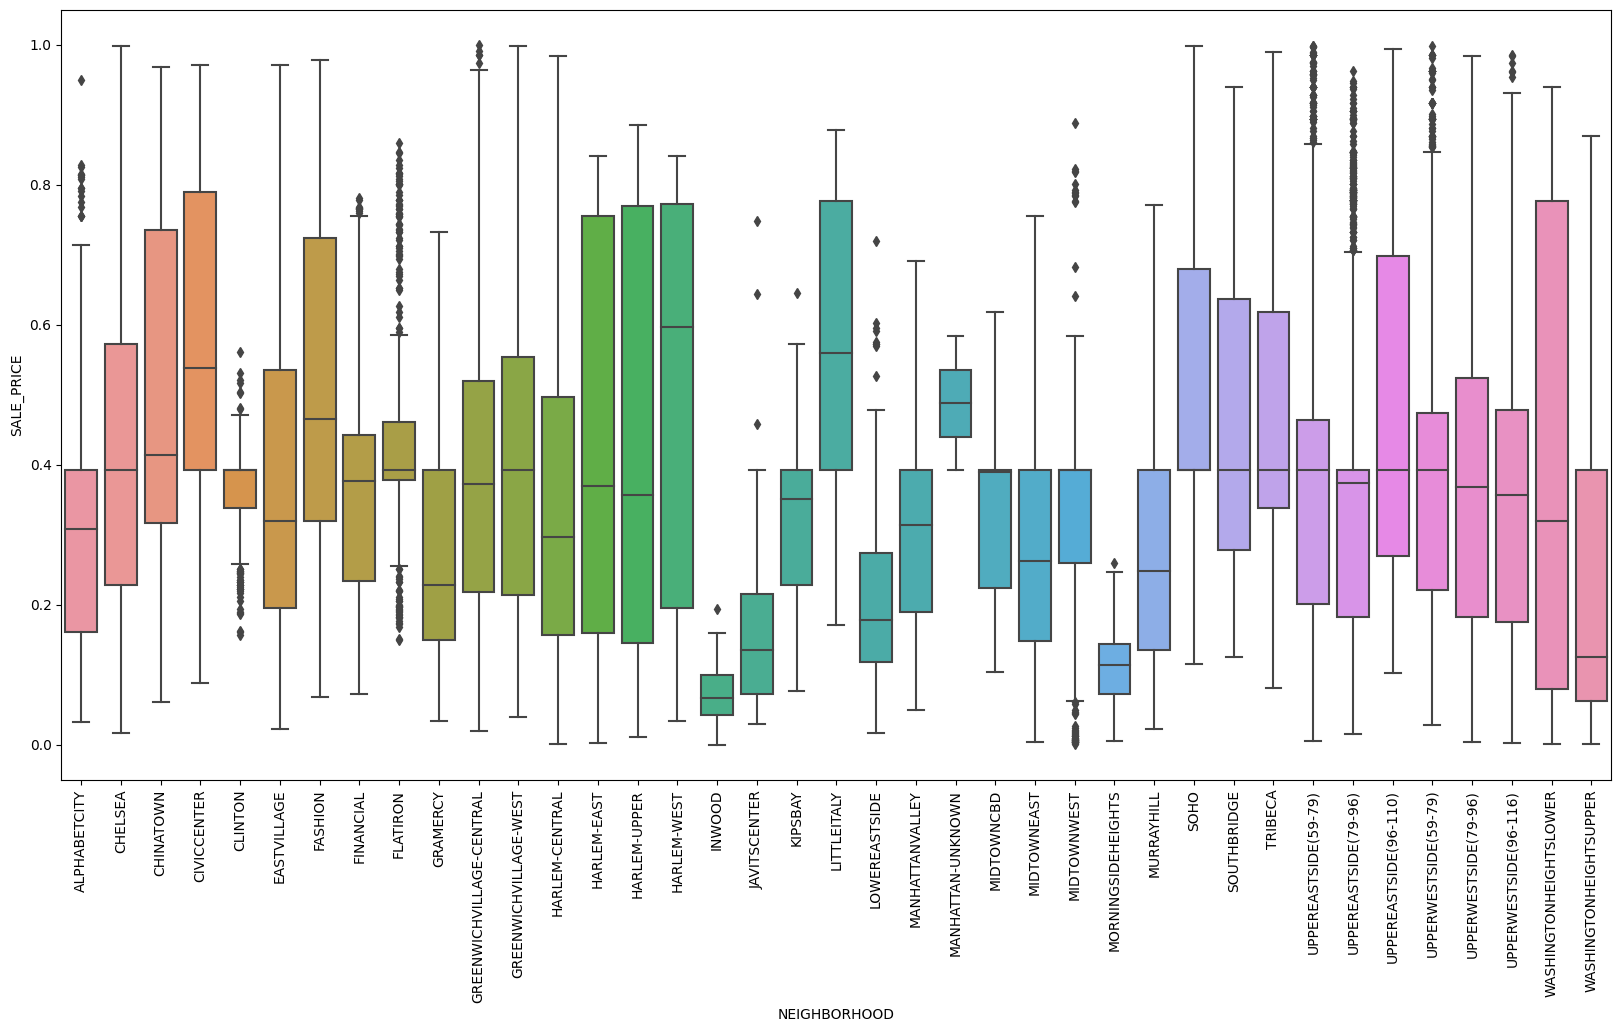

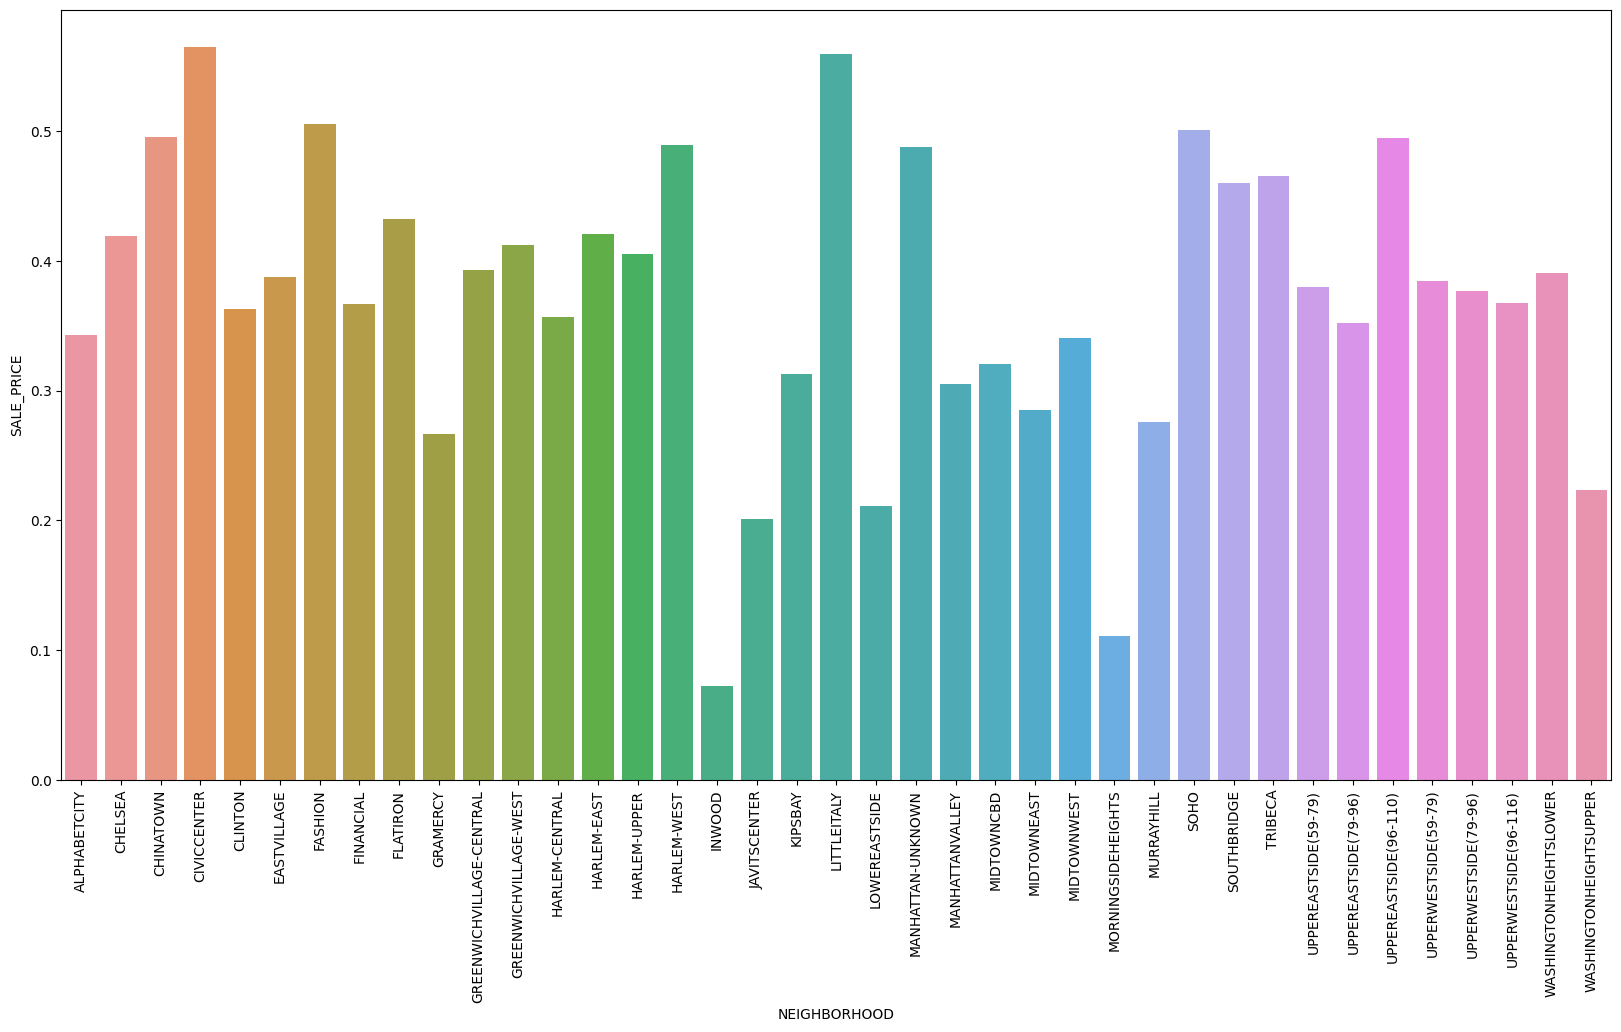

KeyError: "['BOROUGH'] not in index"

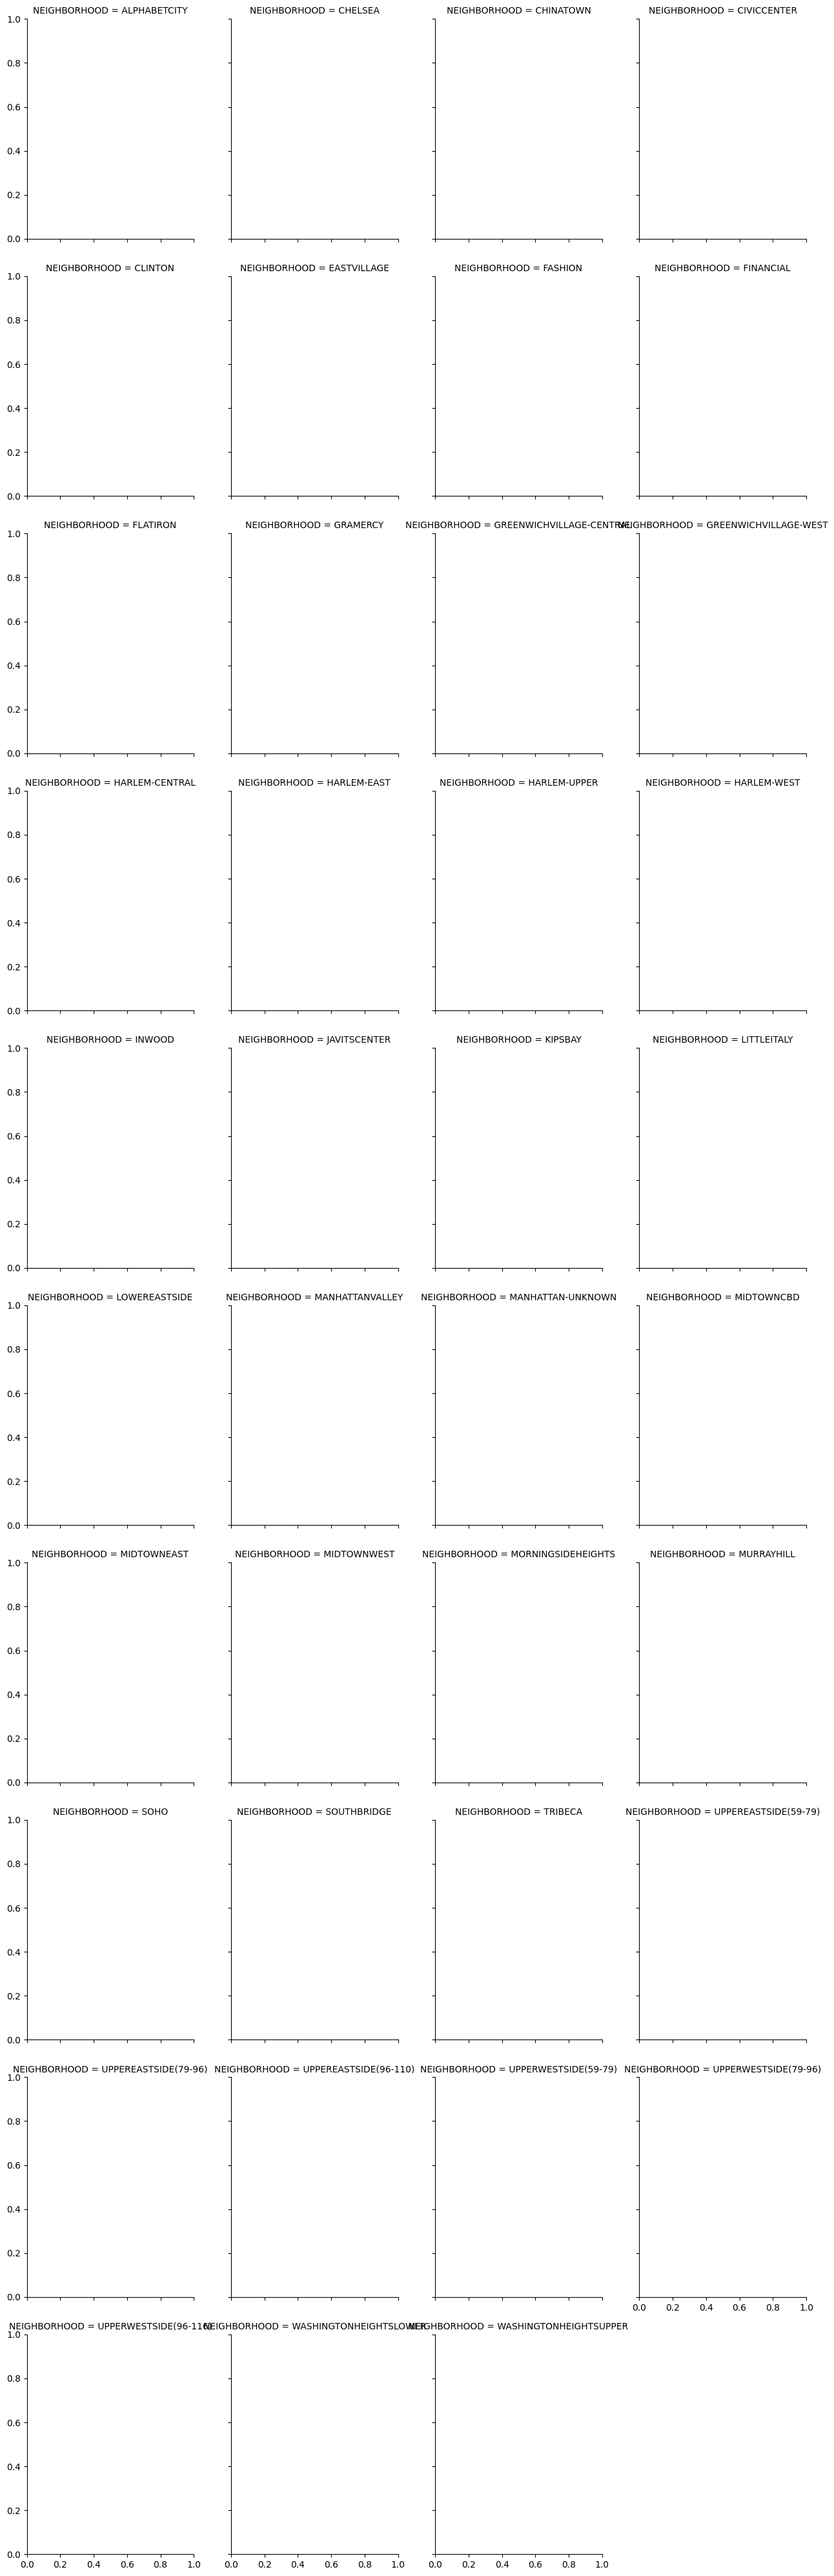

In [222]:
gf.boxPlot(dfnorm, 'SALE_PRICE', 'NEIGHBORHOOD')
gf.averagePrice(dfnorm, 'SALE_PRICE', 'NEIGHBORHOOD')


g = sns.FacetGrid(dfnorm, col='NEIGHBORHOOD', col_wrap=4, height=4, aspect=.8)
g.map(sns.lineplot, 'BOROUGH', 'SALE_PRICE', ci=None)
plt.show()

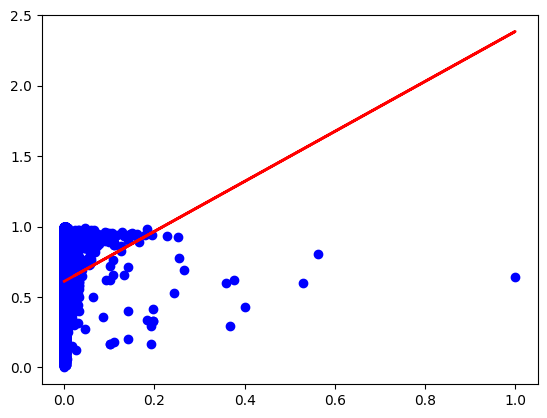


 Intercept            0.611244
RESIDENTIAL_UNITS    1.772620
dtype: float64
confidence interval:
                           0         1
Intercept          0.608183  0.614306
RESIDENTIAL_UNITS  1.583709  1.961531 

P values:
 Intercept            0.000000e+00
RESIDENTIAL_UNITS    8.136739e-75
dtype: float64
R-Squared 0.01965108383277825


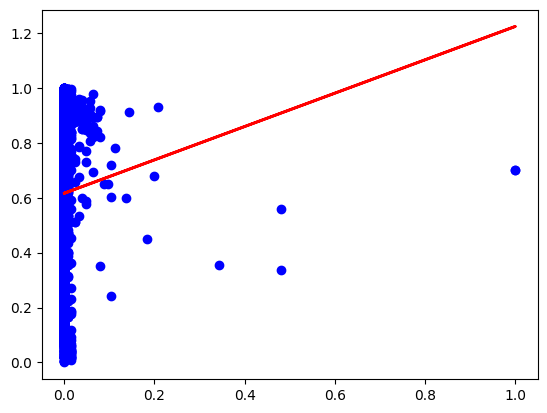


 Intercept           0.616440
COMMERCIAL_UNITS    0.607361
dtype: float64
confidence interval:
                          0         1
Intercept         0.613406  0.619474
COMMERCIAL_UNITS  0.381749  0.832973 

P values:
 Intercept           0.000000e+00
COMMERCIAL_UNITS    1.331404e-07
dtype: float64
R-Squared 0.0016471875246681922


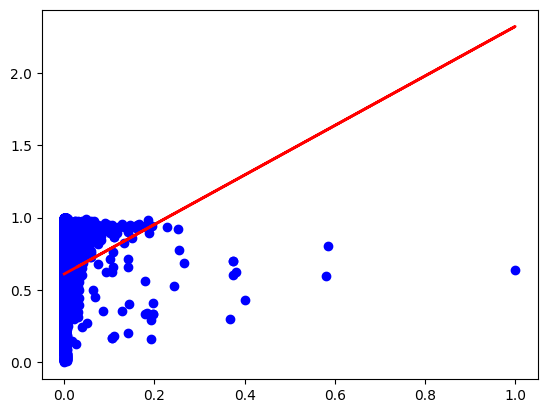


 Intercept      0.610810
TOTAL_UNITS    1.708041
dtype: float64
confidence interval:
                     0         1
Intercept    0.607745  0.613876
TOTAL_UNITS  1.531114  1.884968 

P values:
 Intercept      0.000000e+00
TOTAL_UNITS    4.875836e-79
dtype: float64
R-Squared 0.020776798107173255


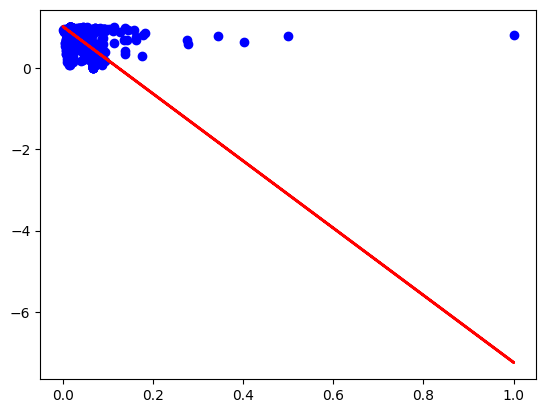


 Intercept           1.017390
LAND_SQUARE_FEET   -8.256955
dtype: float64
confidence interval:
                          0         1
Intercept         1.010229  1.024550
LAND_SQUARE_FEET -8.397045 -8.116866 

P values:
 Intercept           0.0
LAND_SQUARE_FEET    0.0
dtype: float64
R-Squared 0.4416195166309135


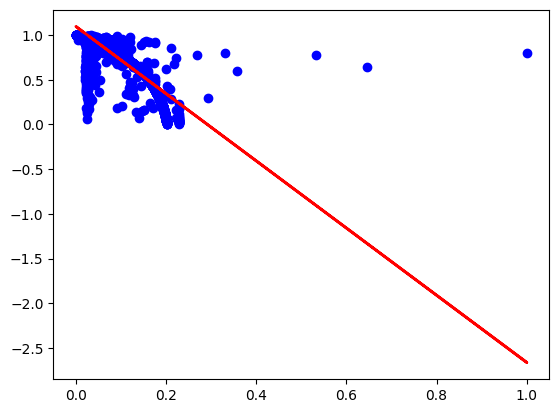


 Intercept            1.096738
GROSS_SQUARE_FEET   -3.760057
dtype: float64
confidence interval:
                           0         1
Intercept          1.092761  1.100715
GROSS_SQUARE_FEET -3.789270 -3.730843 

P values:
 Intercept            0.0
GROSS_SQUARE_FEET    0.0
dtype: float64
R-Squared 0.7904245508084364


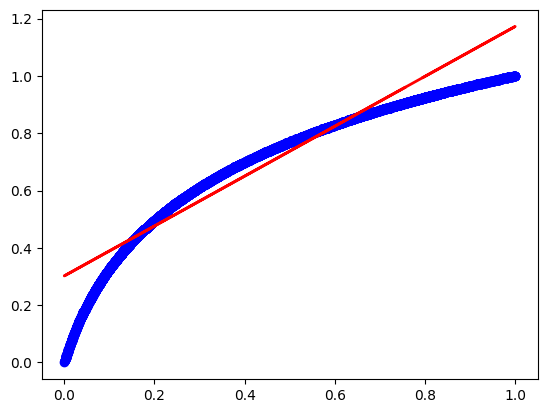


 Intercept     0.302068
SALE_PRICE    0.870277
dtype: float64
confidence interval:
                    0         1
Intercept   0.300233  0.303903
SALE_PRICE  0.865939  0.874614 

P values:
 Intercept     0.0
SALE_PRICE    0.0
dtype: float64
R-Squared 0.9016113531765468


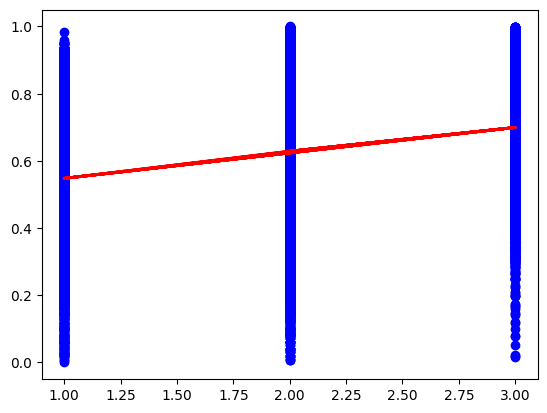


 Intercept                       0.548022
AVG_SALE_PRICE_CATEGORY[T.2]    0.080728
AVG_SALE_PRICE_CATEGORY[T.3]    0.151421
dtype: float64
confidence interval:
                                      0         1
Intercept                     0.542493  0.553550
AVG_SALE_PRICE_CATEGORY[T.2]  0.073955  0.087501
AVG_SALE_PRICE_CATEGORY[T.3]  0.142150  0.160692 

P values:
 Intercept                        0.000000e+00
AVG_SALE_PRICE_CATEGORY[T.2]    7.932400e-119
AVG_SALE_PRICE_CATEGORY[T.3]    2.265332e-218
dtype: float64
R-Squared 0.06141532175077502


In [174]:
#numerical.remove("SALE_PRICE")
numerical.append("AVG_SALE_PRICE_CATEGORY")
for col in numerical:
    if col=="lnprice":
        continue

    gf.regressionFitNumerical(dfnorm, col)



Root Mean Squared Error: 0.06
Cross-validation scores:  [0.96745216 0.71058731 0.96811354 0.97931802 0.95114695]
Mean cross-validation score: 0.92
Y-axis intercept 0.8493
Weight coefficients:
    RESIDENTIAL_UNITS: -3.2194
     COMMERCIAL_UNITS: -1.2568
          TOTAL_UNITS: 3.1887
     LAND_SQUARE_FEET: 5.8371
    GROSS_SQUARE_FEET: -6.0381
R squared for the training data is 0.920
Score against test data: 0.926


<AxesSubplot: xlabel='SALE_PRICE', ylabel='Count'>

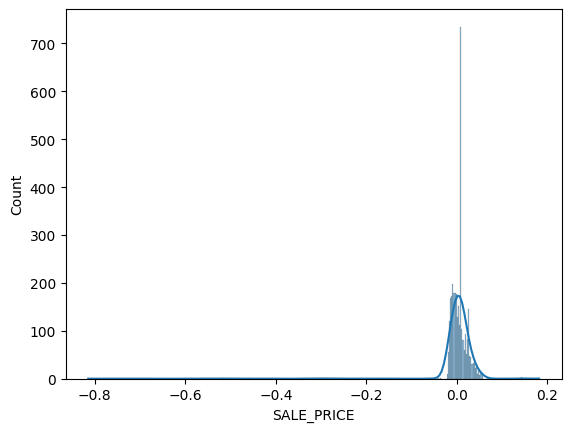

In [175]:

# select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
#         'GROSS_SQUARE_FEET', 'NEIGHBORHOOD']
# # Select predictors
# X = dfnorm[select_features]

# # Encode categorical variables using one-hot encoding
# X = pd.get_dummies(X)

# # Target variable
# Y = dfnorm['lnprice']
# trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
# lm = linear_model.LinearRegression()
# lm.fit(trainX, trainY)
# print("Y-axis intercept {:6.4f}".format(lm.intercept_))
# print("Weight coefficients:")
# for feat, coef in zip(select_features, lm.coef_):
#     print(" {:>20}: {:6.4f}".format(feat, coef))
# # The value of R^2
# print("R squared for the training data is {:4.3f}".format(lm.score(trainX,
# trainY)))
# print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))

select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
# Select predictors
X = dfnorm[select_features]

# Encode categorical variables using one-hot encoding
#X = pd.get_dummies(X)

# Target variable
dfnorm.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
y = dfnorm['SALE_PRICE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

print("Y-axis intercept {:6.4f}".format(model.intercept_))
print("Weight coefficients:")
for feat, coef in zip(select_features, model.coef_):
    print(" {:>20}: {:6.4f}".format(feat, coef))
# The value of R^2
print("R squared for the training data is {:4.3f}".format(model.score(X_train,
y_train)))
print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))

# Plot histogram of residuals
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)

In [176]:
def mse(df, pred, obs):
    n = df.shape[0]
    return sum((df[pred]-df[obs])**2)/n
dfnorm['pred'] = model.predict(X)
print("Mean Squared error: {}".format(mse(dfnorm,'pred', 'SALE_PRICE')))

Mean Squared error: 0.0037702233482669175


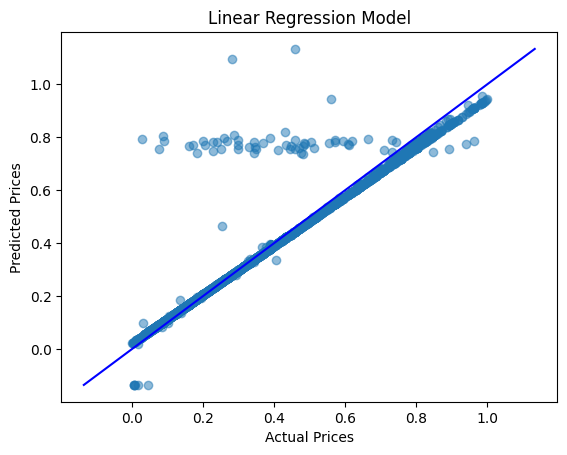

In [177]:
plt.scatter(y_test, y_pred, alpha=0.5)

# Add a regression line to the plot
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')

# Set axis labels and title
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression Model')

# Show the plot
plt.show()

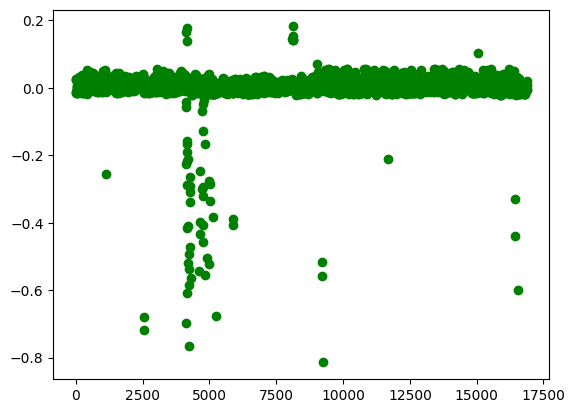

In [178]:
pred=model.predict(X_test)
res=(y_test-pred)
plt.plot(res, 'go')
plt.show()

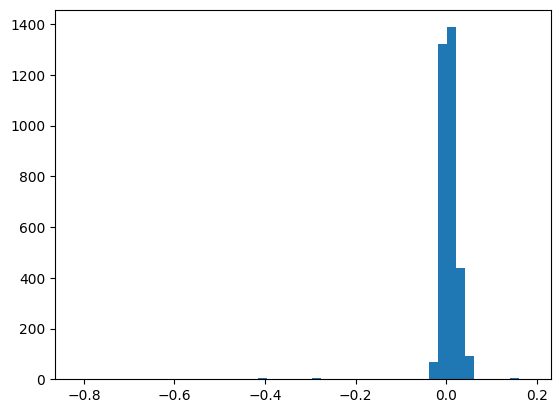

In [179]:
plt.hist(res, bins=50)
plt.show()

In [180]:
RSEd = ((y_test-pred)**2).sum()
RSE = np.sqrt(RSEd/(dfnorm.shape[0]-1-1))
RSE

0.026339721995604685

In [181]:
from sklearn.ensemble import RandomForestRegressor

select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']

# Select predictors
X = dfnorm[select_features]

# Encode categorical variables using one-hot encoding
#X = pd.get_dummies(X)

# Target variable
dfnorm.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
y = dfnorm['SALE_PRICE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

print("Feature importances:")
for feat, importance in zip(select_features, model.feature_importances_):
    print(" {:>20}: {:6.4f}".format(feat, importance))

# The value of R^2
print("R squared for the training data is {:4.3f}".format(model.score(X_train, y_train)))
print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))




Root Mean Squared Error: 0.05
Cross-validation scores:  [0.95649661 0.78304087 0.96783079 0.98703764 0.95197893]
Mean cross-validation score: 0.93
Feature importances:
    RESIDENTIAL_UNITS: 0.0049
     COMMERCIAL_UNITS: 0.0021
          TOTAL_UNITS: 0.0050
     LAND_SQUARE_FEET: 0.0337
    GROSS_SQUARE_FEET: 0.9543
R squared for the training data is 0.989
Score against test data: 0.936


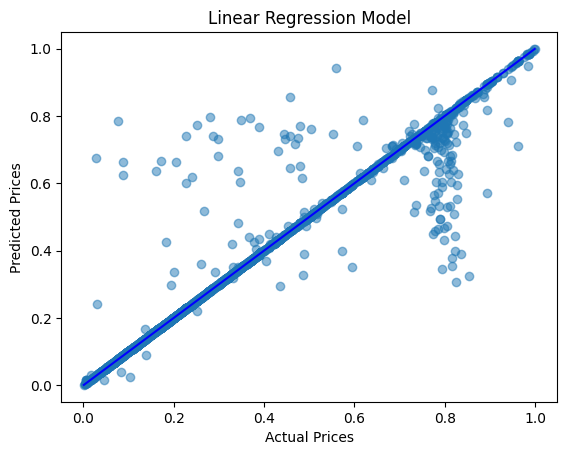

In [182]:
plt.scatter(y_test, y_pred, alpha=0.5)

# Add a regression line to the plot
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')

# Set axis labels and title
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression Model')

# Show the plot
plt.show()

In [223]:
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE', 'lnprice']
model = KMeans(n_clusters=8)
model.fit(dfnorm[numerical])

## J score
print('J-score = ', model.inertia_)
#print(' score = ', model.score(df_norm))
## include the labels into the data
print(model.labels_)


labels = model.labels_
md = pd.Series(labels)
dfnorm['clust'] = md
dfnorm.head(5)



c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


J-score =  53.13717117976804
[5 0 5 ... 7 5 5]


,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,...,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,lnprice,AVG_SALE_PRICE,AVG_SALE_PRICE_CATEGORY,clust
0,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2B,374,1,C7,303EAST4THSTREET,10009,0.023952,0.016,...,0.031225,1900.0,2,C7,0.754914,2013-02-05,0.904711,899788.974971,1,5
1,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2,376,30,C4,274EASTSEVENTHSTREET,10009,0.038922,0.000,...,0.042542,1910.0,2,C4,0.340862,2012-10-25,0.649338,899788.974971,1,0
2,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2B,384,25,C4,241EAST2NDSTREET,10009,0.029940,0.000,...,0.031534,1900.0,2,C4,0.767953,2013-04-18,0.910456,899788.974971,1,5
3,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2B,398,52,C7,174EAST2NDSTREET,10009,0.026946,0.008,...,0.028096,1900.0,2,C7,0.813922,2013-01-07,0.930020,899788.974971,1,5
4,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2B,398,52,C7,174EAST2NDSTREET,10009,0.026946,0.008,...,0.028096,1900.0,2,C7,0.813922,2012-10-26,0.930020,899788.974971,1,5


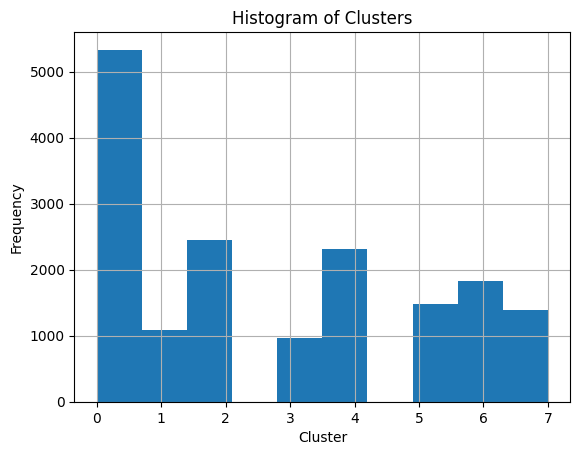

C:\Users\zacha\AppData\Local\Temp\ipykernel_8120\2308593350.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfnorm.groupby('clust').mean()


,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,lnprice,AVG_SALE_PRICE
clust,,,,,,,,,,,,,
0,1108.430259,995.765279,10033.998500,0.002155,0.000945,0.002612,0.047567,0.122924,1958.093738,2.169104,0.388642,0.689267,9.519873e+05
1,1084.003693,680.444137,10033.590028,0.004125,0.002061,0.004904,0.031743,0.062892,1947.785780,2.134811,0.679288,0.868796,1.002981e+06
2,1143.726200,536.746135,10030.101302,0.001385,0.000130,0.001437,0.057648,0.163678,1949.527665,2.008137,0.182877,0.469790,9.098232e+05
3,1471.410917,309.416066,10031.645726,0.001184,0.000560,0.001397,0.064760,0.192155,1939.393409,2.069001,0.046738,0.182598,8.409508e+05
4,1103.884533,734.866006,10030.214132,0.002628,0.000462,0.002803,0.053006,0.144900,1954.646273,2.007324,0.273246,0.582001,9.405116e+05
5,1134.251517,459.472690,10033.351315,0.014520,0.003026,0.015659,0.023018,0.030642,1932.575860,2.038436,0.835716,0.938050,1.029672e+06
6,1232.591926,434.400982,10033.972177,0.001333,0.000537,0.001544,0.061545,0.178963,1946.900164,2.019094,0.109601,0.343712,8.778003e+05
7,1085.368459,758.606452,10031.043728,0.002958,0.000453,0.003146,0.039997,0.093897,1953.678853,2.051613,0.522956,0.782867,9.656196e+05


In [224]:


## histogram of the clusters
plt.hist(dfnorm['clust'])
plt.title('Histogram of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.grid()
plt.show()

dfnorm.groupby('clust').mean()

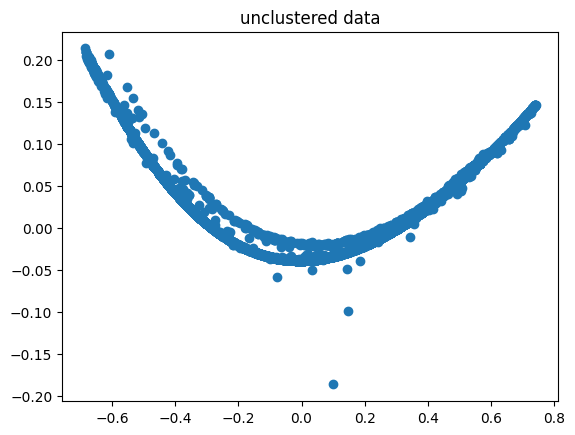

In [186]:
pca_data = PCA(n_components=2).fit(dfnorm[numerical])
pca_2d = pca_data.transform(dfnorm[numerical])
plt.scatter(pca_2d[:,0], pca_2d[:,1])
plt.title('unclustered data')
plt.show()

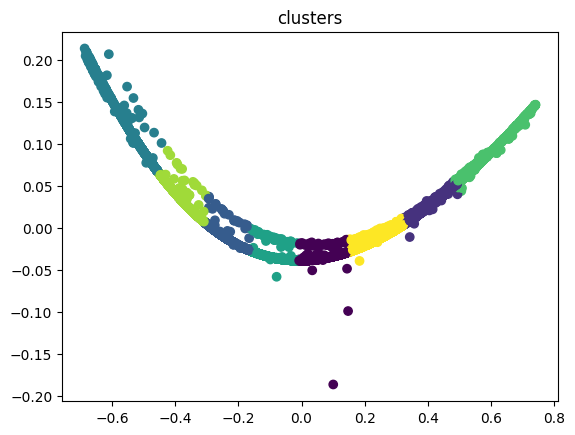

In [225]:
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels)
plt.title('clusters')
plt.show()


Plotting elbow method...
2 422.1781372179543
4 147.62284493017103
6 80.91649601308734
8 52.68644407428829
10 40.75310070446092
12 32.87330277462812
14 26.92525799148155
16 22.650062708335472
18 18.416820677503278


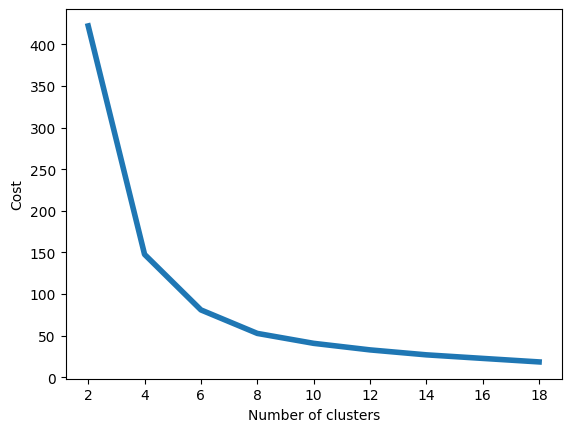

DONE


In [121]:


def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 20, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")
elbow(dfnorm[numerical])



In [226]:
def localRegressors(df, clusters, features, target):
    model_dict={}
    cluster_dict={}
    for cluster in range(clusters):
        clustData=df[df['clust'] == cluster].copy()
        if clustData.empty:
            continue
        x=clustData[features]
        y=clustData[target]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(x_train,y_train)
        model_dict[cluster]=model
        cluster_dict[cluster]={'x':x,'x_train':x_train, 'x_test':x_test, 'y':y, 'y_train':y_train, 'y_test':y_test}
    
    return model_dict, cluster_dict
features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
models, clusters=localRegressors(dfnorm, 8, features, 'SALE_PRICE')
print(models)

{0: RandomForestRegressor(random_state=42), 1: RandomForestRegressor(random_state=42), 2: RandomForestRegressor(random_state=42), 3: RandomForestRegressor(random_state=42), 4: RandomForestRegressor(random_state=42), 5: RandomForestRegressor(random_state=42), 6: RandomForestRegressor(random_state=42), 7: RandomForestRegressor(random_state=42)}


In [228]:
def testClusters(df, models,clusters):
    for cluster, model in models.items():
        clustData=clusters[cluster]
        x = clustData['x']
        y = clustData['y']
        x_test=clustData['x_test']
        x_train=clustData['x_train']
        y_test=clustData['y_test']
        y_train=clustData['y_train']
        cv_scores = cross_val_score(model, x, y, cv=5)
        print("Cluster {} - Cross-validation scores: ".format(cluster), cv_scores)
        print("Cluster {} - Mean cross-validation score: {:.2f}".format(cluster, np.mean(cv_scores)))
        print("Cluster {} - Feature importances:".format(cluster))
        for feat, importance in zip(features, model.feature_importances_):
            print(" {:>20}: {:6.4f}".format(feat, importance))
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print("Cluster {} - Root Mean Squared Error: {:.2f}".format(cluster, rmse))
        print("Cluster {} - R squared for the training data is {:4.3f}".format(cluster, model.score(x_train, y_train)))
        print("Cluster {} - Score against test data: {:4.3f}".format(cluster, model.score(x_test, y_test)))

        plt.scatter(y_test, y_pred, alpha=0.5)
        p1 = max(max(y_pred), max(y_test))
        p2 = min(min(y_pred), min(y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.title('Linear Regression Model - Cluster {}'.format(cluster))
        plt.show()

Cluster 0 - Cross-validation scores:  [0.94930144 0.83109829 0.93125522 0.99994295 0.99302216]
Cluster 0 - Mean cross-validation score: 0.94
Cluster 0 - Feature importances:
    RESIDENTIAL_UNITS: 0.0063
     COMMERCIAL_UNITS: 0.0046
          TOTAL_UNITS: 0.0080
     LAND_SQUARE_FEET: 0.1049
    GROSS_SQUARE_FEET: 0.8761
Cluster 0 - Root Mean Squared Error: 0.00
Cluster 0 - R squared for the training data is 0.989
Cluster 0 - Score against test data: 0.980


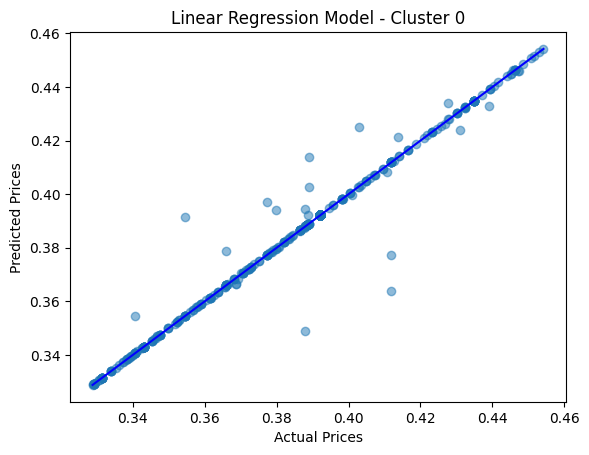

Cluster 1 - Cross-validation scores:  [0.93488739 0.58235208 0.96975302 0.9798095  0.9898813 ]
Cluster 1 - Mean cross-validation score: 0.89
Cluster 1 - Feature importances:
    RESIDENTIAL_UNITS: 0.0069
     COMMERCIAL_UNITS: 0.0126
          TOTAL_UNITS: 0.0113
     LAND_SQUARE_FEET: 0.1669
    GROSS_SQUARE_FEET: 0.8024
Cluster 1 - Root Mean Squared Error: 0.01
Cluster 1 - R squared for the training data is 0.991
Cluster 1 - Score against test data: 0.898


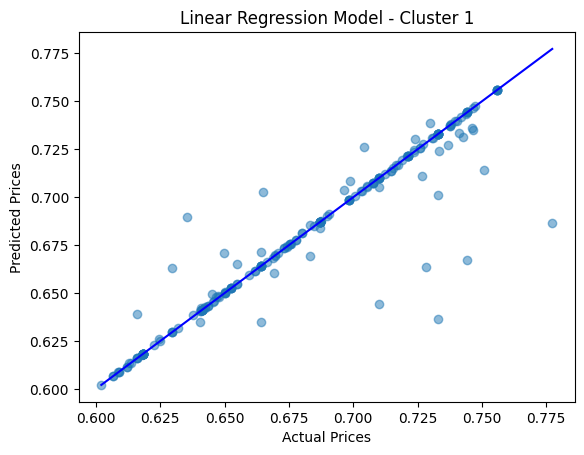

Cluster 2 - Cross-validation scores:  [0.97317534 0.93222673 0.99605079 0.99999555 0.96338696]
Cluster 2 - Mean cross-validation score: 0.97
Cluster 2 - Feature importances:
    RESIDENTIAL_UNITS: 0.0026
     COMMERCIAL_UNITS: 0.0005
          TOTAL_UNITS: 0.0026
     LAND_SQUARE_FEET: 0.7979
    GROSS_SQUARE_FEET: 0.1964
Cluster 2 - Root Mean Squared Error: 0.01
Cluster 2 - R squared for the training data is 0.996
Cluster 2 - Score against test data: 0.951


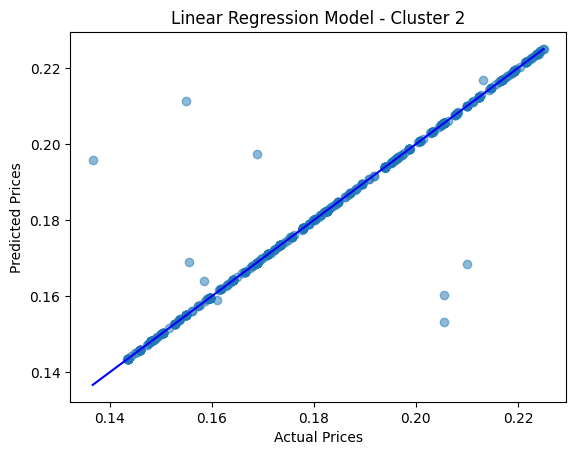

Cluster 3 - Cross-validation scores:  [0.94148441 0.92510013 0.97194801 0.98782862 0.97165426]
Cluster 3 - Mean cross-validation score: 0.96
Cluster 3 - Feature importances:
    RESIDENTIAL_UNITS: 0.0009
     COMMERCIAL_UNITS: 0.0003
          TOTAL_UNITS: 0.0018
     LAND_SQUARE_FEET: 0.3274
    GROSS_SQUARE_FEET: 0.6697
Cluster 3 - Root Mean Squared Error: 0.00
Cluster 3 - R squared for the training data is 0.978
Cluster 3 - Score against test data: 0.939


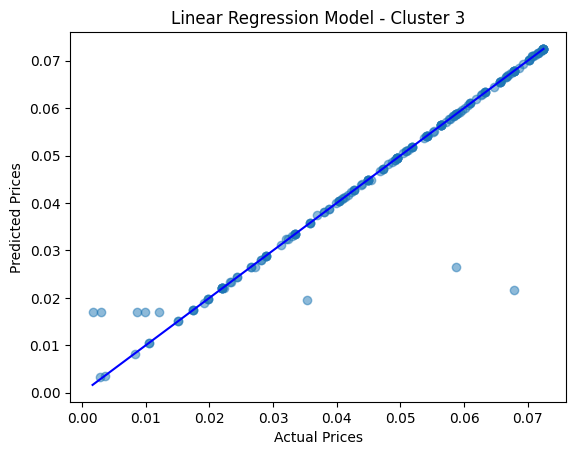

Cluster 4 - Cross-validation scores:  [0.99728356 0.9095474  0.99300673 0.97336595 0.97905091]
Cluster 4 - Mean cross-validation score: 0.97
Cluster 4 - Feature importances:
    RESIDENTIAL_UNITS: 0.0056
     COMMERCIAL_UNITS: 0.0016
          TOTAL_UNITS: 0.0079
     LAND_SQUARE_FEET: 0.2880
    GROSS_SQUARE_FEET: 0.6969
Cluster 4 - Root Mean Squared Error: 0.00
Cluster 4 - R squared for the training data is 0.996
Cluster 4 - Score against test data: 0.984


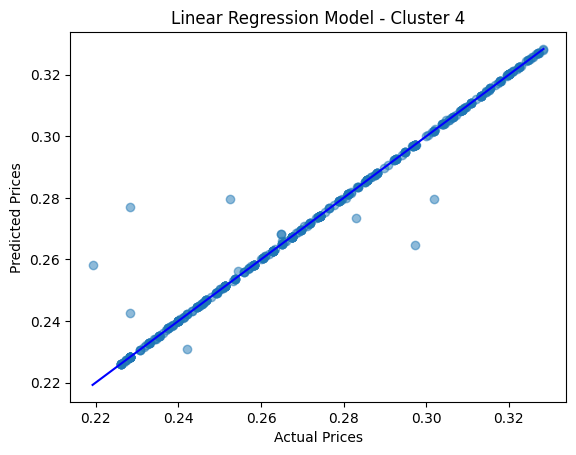

Cluster 5 - Cross-validation scores:  [0.90197583 0.80128204 0.93182693 0.93827591 0.87469447]
Cluster 5 - Mean cross-validation score: 0.89
Cluster 5 - Feature importances:
    RESIDENTIAL_UNITS: 0.0070
     COMMERCIAL_UNITS: 0.0054
          TOTAL_UNITS: 0.0251
     LAND_SQUARE_FEET: 0.1765
    GROSS_SQUARE_FEET: 0.7861
Cluster 5 - Root Mean Squared Error: 0.02
Cluster 5 - R squared for the training data is 0.984
Cluster 5 - Score against test data: 0.929


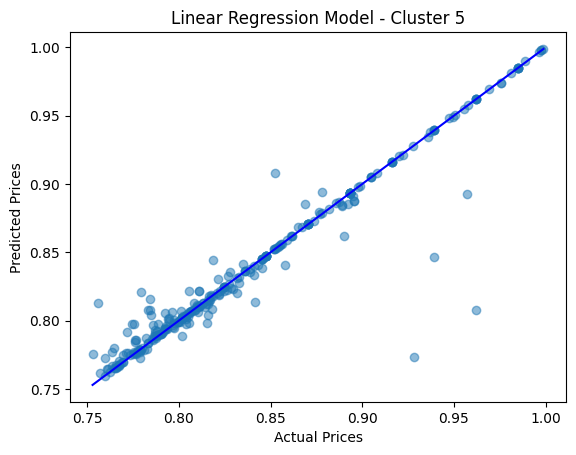

Cluster 6 - Cross-validation scores:  [0.98103473 0.9734743  0.99921321 0.98245418 0.9879085 ]
Cluster 6 - Mean cross-validation score: 0.98
Cluster 6 - Feature importances:
    RESIDENTIAL_UNITS: 0.0021
     COMMERCIAL_UNITS: 0.0003
          TOTAL_UNITS: 0.0024
     LAND_SQUARE_FEET: 0.4748
    GROSS_SQUARE_FEET: 0.5204
Cluster 6 - Root Mean Squared Error: 0.00
Cluster 6 - R squared for the training data is 0.998
Cluster 6 - Score against test data: 0.968


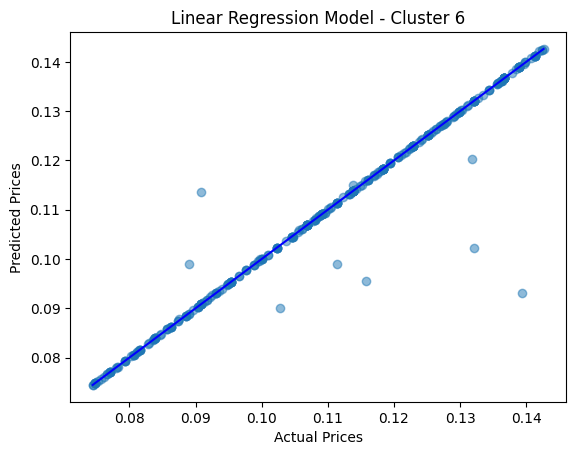

Cluster 7 - Cross-validation scores:  [0.96410015 0.64825165 0.96795484 0.99900694 0.96866582]
Cluster 7 - Mean cross-validation score: 0.91
Cluster 7 - Feature importances:
    RESIDENTIAL_UNITS: 0.0092
     COMMERCIAL_UNITS: 0.0062
          TOTAL_UNITS: 0.0084
     LAND_SQUARE_FEET: 0.0800
    GROSS_SQUARE_FEET: 0.8962
Cluster 7 - Root Mean Squared Error: 0.01
Cluster 7 - R squared for the training data is 0.990
Cluster 7 - Score against test data: 0.943


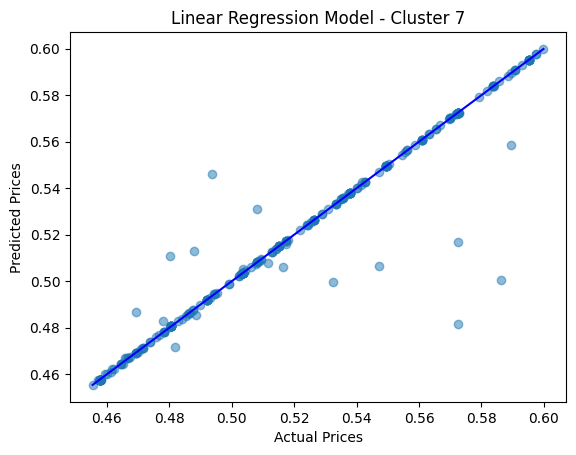

In [229]:
testClusters(dfnorm, models, clusters)